In [64]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

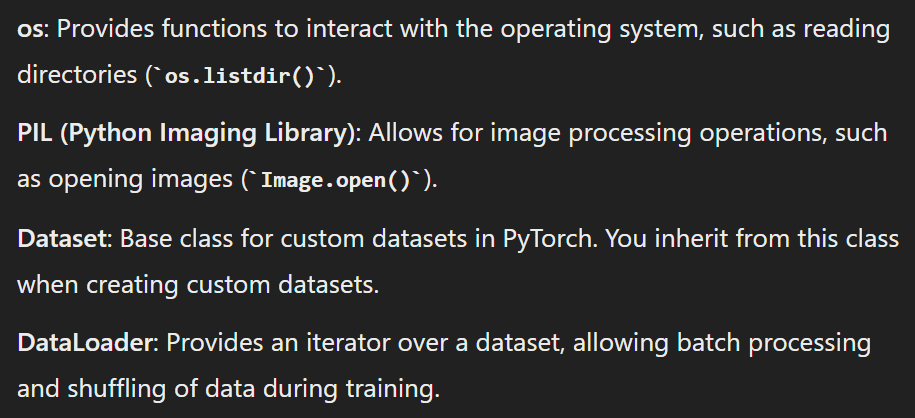

In [65]:
train_df = pd.DataFrame(columns=["img_name","label"])
train_df["img_name"] = os.listdir("./train")
for idx,i in enumerate(os.listdir("./train")):
    if "cat" in i:
        train_df.at[idx,"label"]=0
    if "dog" in i:
        train_df.at[idx,"label"]=1

train_df.to_csv(r'train_csv.csv',index=False,header=True)

In [66]:
class customdataset(Dataset):
    def __init__(self,root_dir,annotation_file,transform=None):
        self.root_dir=root_dir
        self.transform=transform
        self.image_files=pd.read_csv(annotation_file)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.image_files.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


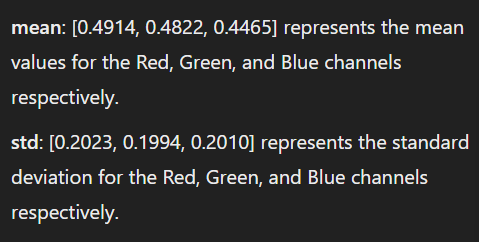

In [67]:
#uses transforms.compose method to reformat images for modeling
all_transforms = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])])

In [68]:
batch_size=32
num_classes=2
learning_rate=0.001
num_epochs=10

In [69]:
full_dataset=customdataset(root_dir='./train',annotation_file='train_csv.csv',transform=all_transforms)
train_size=int(0.7 * len(full_dataset))
test_size=int(0.2 * len(full_dataset))
validate_size= int(len(full_dataset))-train_size-test_size

In [70]:
train_dataset,test_dataset,validate_dataset=random_split(full_dataset,[train_size,test_size,validate_size])

In [71]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(dataset=validate_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


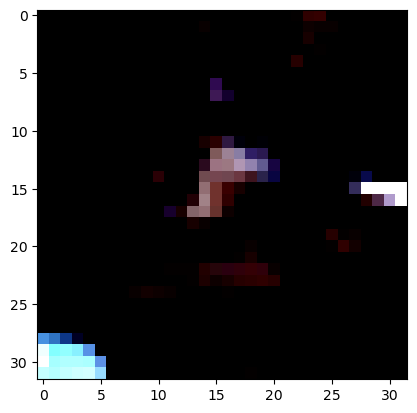

In [72]:
# Check a sample image
sample_image, _ = train_dataset[100]
plt.imshow(sample_image.permute(1, 2, 0).numpy()) 
plt.show()

In [73]:
import matplotlib.pyplot as plt
import numpy as np

In [74]:
class convNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(convNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x): 
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.maxpool1(out)
    
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.maxpool2(out)
        
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [80]:
model=convNeuralNet(num_classes)
model.load_state_dict(torch.load("CatvsDoggo.pth"))
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=0.005,momentum=0.9)

In [81]:
for epoch in range(num_epochs):
    model.train()  
    for inputs, labels in train_loader: 
        y_pred = model(inputs)
        loss = criterion(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval() 
    acc = 0
    count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            y_pred = model(inputs)
            acc += (torch.argmax(y_pred, 1) == labels).float().sum()
            count += len(labels)
    acc /= count
    print(f"Epoch {epoch+1}: model accuracy {acc*100:.4f}%")

Epoch 1: model accuracy 74.1600%
Epoch 2: model accuracy 73.8000%
Epoch 3: model accuracy 75.4800%
Epoch 4: model accuracy 73.6000%
Epoch 5: model accuracy 75.4800%
Epoch 6: model accuracy 75.4200%
Epoch 7: model accuracy 77.0600%
Epoch 8: model accuracy 76.7600%
Epoch 9: model accuracy 77.0400%
Epoch 10: model accuracy 77.4000%


In [77]:
model.eval()
val_acc = 0
val_count = 0
with torch.no_grad():
    for inputs, labels in validate_loader:
        y_pred = model(inputs)
        val_acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        val_count += len(labels)
val_acc /= val_count
print(f"Validation accuracy {val_acc*100:.2f}%")

Validation accuracy 72.32%


In [78]:
torch.save(model.state_dict(), "CatvsDoggo.pth")